In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(train_df,test_df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    oof_pred_labels= np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    sub_pred_labels = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        test_x, test_y = test_df[feats], test_df['TARGET']

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        oof_pred_labels[valid_idx] =np.round(oof_preds[valid_idx])
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        sub_pred_labels=np.round(sub_preds)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        print('Fold %2d RECALL : %.6f' % (n_fold + 1,recall_score(valid_y,oof_pred_labels[valid_idx])))
        print('Fold %2d ACC : %.6f' % (n_fold + 1,accuracy_score(valid_y,oof_pred_labels[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(test_y, sub_pred_labels))
    print('Full RECALL %.6f' % (recall_score(test_y,sub_pred_labels)))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df



In [13]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


In [14]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [15]:
train_df=pd.read_csv('train_data.csv')
test_df=pd.read_csv('test_data.csv')
submission_file_name = "lgbm_result.csv"

Starting LightGBM. Train shape: (10995, 171), test shape: (3666, 171)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.953915	training's binary_logloss: 0.122563	valid_1's auc: 0.949772	valid_1's binary_logloss: 0.116579
[400]	training's auc: 0.969369	training's binary_logloss: 0.0983486	valid_1's auc: 0.962492	valid_1's binary_logloss: 0.0962059
[600]	training's auc: 0.975924	training's binary_logloss: 0.0868439	valid_1's auc: 0.965302	valid_1's binary_logloss: 0.0879513
[800]	training's auc: 0.980001	training's binary_logloss: 0.0796036	valid_1's auc: 0.96697	valid_1's binary_logloss: 0.0823987
[1000]	training's auc: 0.982649	training's binary_logloss: 0.0743791	valid_1's auc: 0.969065	valid_1's binary_logloss: 0.0789082
[1200]	training's auc: 0.984818	training's binary_logloss: 0.0702135	valid_1's auc: 0.970244	valid_1's binary_logloss: 0.0765818
[1400]	training's auc: 0.986662	training's binary_logloss: 0.0666688	valid_1's auc: 0.970458	valid_1's binary_logloss: 0.0753154
Fold  1 AUC : 0.970821
Fold  1 RECALL : 0.794872
Fold  1 ACC : 0.984545
[LightGBM] [Warning] num_threads

C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.957208	training's binary_logloss: 0.120324	valid_1's auc: 0.948423	valid_1's binary_logloss: 0.114767
[400]	training's auc: 0.97083	training's binary_logloss: 0.0967187	valid_1's auc: 0.955889	valid_1's binary_logloss: 0.0956322
[600]	training's auc: 0.977443	training's binary_logloss: 0.0858503	valid_1's auc: 0.960065	valid_1's binary_logloss: 0.0884541
[800]	training's auc: 0.981508	training's binary_logloss: 0.0790076	valid_1's auc: 0.961249	valid_1's binary_logloss: 0.0844869
[1000]	training's auc: 0.984274	training's binary_logloss: 0.0740725	valid_1's auc: 0.962172	valid_1's binary_logloss: 0.0815352
[1200]	training's auc: 0.986389	training's binary_logloss: 0.0699934	valid_1's auc: 0.96359	valid_1's binary_logloss: 0.0789058
[1400]	training's auc: 0.988203	training's binary_logloss: 0.0665096	valid_1's auc: 0.965099	valid_1's binary_logloss: 0.0766494
[1600]	training's auc: 0.989442	training's binary_logloss: 0.0638756	valid_1's auc: 0.96761	valid_1's bin

C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.957275	training's binary_logloss: 0.120241	valid_1's auc: 0.916559	valid_1's binary_logloss: 0.132501
[400]	training's auc: 0.97133	training's binary_logloss: 0.0956478	valid_1's auc: 0.923706	valid_1's binary_logloss: 0.115835
[600]	training's auc: 0.978036	training's binary_logloss: 0.0847904	valid_1's auc: 0.923476	valid_1's binary_logloss: 0.109791
Fold  3 AUC : 0.924597
Fold  3 RECALL : 0.513889
Fold  3 ACC : 0.968182
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.955101	training's binary_logloss: 0.121208	valid_1's auc: 0.929121	valid_1's binary_logloss: 0.127898
[400]	training's auc: 0.970596	training's binary_logloss: 0.0969656	valid_1's auc: 0.942164	valid_1's binary_logloss: 0.110015
[600]	training's auc: 0.977415	training's binary_logloss: 0.0859367	valid_1's auc: 0.949528	valid_1's binary_logloss: 0.102616
[800]	training's auc: 0.981171	training's binary_logloss: 0.0790712	valid_1's auc: 0.953372	valid_1's binary_logloss: 0.0980494
[1000]	training's auc: 0.984264	training's binary_logloss: 0.0735854	valid_1's auc: 0.955293	valid_1's binary_logloss: 0.095093
[1200]	training's auc: 0.986544	training's binary_logloss: 0.0693814	valid_1's auc: 0.958579	valid_1's binary_logloss: 0.0928246
[1400]	training's auc: 0.988506	training's binary_logloss: 0.0657123	valid_1's auc: 0.958207	valid_1's binary_logloss: 0.0917235
Fold  4 AUC : 0.958678
Fold  4 RECALL : 0.645570
Fold  4 ACC : 0.971818


C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.956106	training's binary_logloss: 0.121206	valid_1's auc: 0.922263	valid_1's binary_logloss: 0.130076
[400]	training's auc: 0.969697	training's binary_logloss: 0.0981395	valid_1's auc: 0.937856	valid_1's binary_logloss: 0.108645
[600]	training's auc: 0.976084	training's binary_logloss: 0.0872202	valid_1's auc: 0.942751	valid_1's binary_logloss: 0.10047
[800]	training's auc: 0.980055	training's binary_logloss: 0.0798346	valid_1's auc: 0.945045	valid_1's binary_logloss: 0.0952165
[1000]	training's auc: 0.983048	training's binary_logloss: 0.0747674	valid_1's auc: 0.946939	valid_1's binary_logloss: 0.0927834
[1200]	training's auc: 0.985407	training's binary_logloss: 0.0705342	valid_1's auc: 0.948407	valid_1's binary_logloss: 0.0905036
[1400]	training's auc: 0.987519	training's binary_logloss: 0.0668661	valid_1's auc: 0.949634	valid_1's binary_logloss: 0.0

C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.952729	training's binary_logloss: 0.121937	valid_1's auc: 0.950514	valid_1's binary_logloss: 0.129169
[400]	training's auc: 0.969168	training's binary_logloss: 0.0971917	valid_1's auc: 0.962455	valid_1's binary_logloss: 0.107877
[600]	training's auc: 0.97592	training's binary_logloss: 0.0861036	valid_1's auc: 0.96454	valid_1's binary_logloss: 0.099663
[800]	training's auc: 0.980758	training's binary_logloss: 0.0784874	valid_1's auc: 0.966398	valid_1's binary_logloss: 0.095528
[1000]	training's auc: 0.983816	training's binary_logloss: 0.0731583	valid_1's auc: 0.967616	valid_1's binary_logloss: 0.0926288
[1200]	training's auc: 0.985831	training's binary_logloss: 0.0690405	valid_1's auc: 0.968194	valid_1's binary_logloss: 0.0905527
[1400]	training's auc: 0.98742	training's binary_logloss: 0.0657601	valid_1's auc: 0.967428	valid_1's binary_logloss: 0.0898894
Fold  6 AUC : 0.968332
Fold  6 RECALL : 0.628205
Fold  6 ACC : 0.971793
[LightGBM] [Warning] num_threads is s

C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.954975	training's binary_logloss: 0.12062	valid_1's auc: 0.947657	valid_1's binary_logloss: 0.143791
[400]	training's auc: 0.96978	training's binary_logloss: 0.0965359	valid_1's auc: 0.957908	valid_1's binary_logloss: 0.122251
[600]	training's auc: 0.976543	training's binary_logloss: 0.0852845	valid_1's auc: 0.962872	valid_1's binary_logloss: 0.113655
[800]	training's auc: 0.98046	training's binary_logloss: 0.0783152	valid_1's auc: 0.965198	valid_1's binary_logloss: 0.108586
[1000]	training's auc: 0.983466	training's binary_logloss: 0.0730567	valid_1's auc: 0.967026	valid_1's binary_logloss: 0.104876
[1200]	training's auc: 0.985347	training's binary_logloss: 0.0690198	valid_1's auc: 0.968075	valid_1's binary_logloss: 0.10252
[1400]	training's auc: 0.986885	training's binary_logloss: 0.0657753	valid_1's auc: 0.968189	valid_1's binary_logloss: 0.10099
[1600]	training's auc: 0.988133	training's binary_logloss: 0.063136	valid_1's auc: 0.968283	valid_1's binary_loglo

C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.955832	training's binary_logloss: 0.12011	valid_1's auc: 0.934742	valid_1's binary_logloss: 0.134984
[400]	training's auc: 0.971435	training's binary_logloss: 0.095703	valid_1's auc: 0.936693	valid_1's binary_logloss: 0.118069
[600]	training's auc: 0.978516	training's binary_logloss: 0.0844065	valid_1's auc: 0.940923	valid_1's binary_logloss: 0.111173
[800]	training's auc: 0.982875	training's binary_logloss: 0.0770453	valid_1's auc: 0.941054	valid_1's binary_logloss: 0.108407
Fold  8 AUC : 0.941632
Fold  8 RECALL : 0.670330
Fold  8 ACC : 0.969063
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.954495	training's binary_logloss: 0.12257	valid_1's auc: 0.951273	valid_1's binary_logloss: 0.109815
[400]	training's auc: 0.969653	training's binary_logloss: 0.0986484	valid_1's auc: 0.959828	valid_1's binary_logloss: 0.0894705
[600]	training's auc: 0.976283	training's binary_logloss: 0.0873748	valid_1's auc: 0.959941	valid_1's binary_logloss: 0.0813272
Fold  9 AUC : 0.960855
Fold  9 RECALL : 0.666667
Fold  9 ACC : 0.978162
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\65873\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.955658	training's binary_logloss: 0.118703	valid_1's auc: 0.891458	valid_1's binary_logloss: 0.171005
[400]	training's auc: 0.97029	training's binary_logloss: 0.0944711	valid_1's auc: 0.909993	valid_1's binary_logloss: 0.153051
[600]	training's auc: 0.977251	training's binary_logloss: 0.0838691	valid_1's auc: 0.917519	valid_1's binary_logloss: 0.145298
[800]	training's auc: 0.981444	training's binary_logloss: 0.076739	valid_1's auc: 0.921351	valid_1's binary_logloss: 0.140025
[1000]	training's auc: 0.983963	training's binary_logloss: 0.0715847	valid_1's auc: 0.925225	valid_1's binary_logloss: 0.136879
[1200]	training's auc: 0.98622	training's binary_logloss: 0.0675813	valid_1's auc: 0.926993	valid_1's binary_logloss: 0.134766
[1400]	training's auc: 0.987564	training's binary_logloss: 0.0646267	valid_1's auc: 0.928506	valid_1's binary_logloss: 0.133049
[1600]	training's auc: 0.98879	training's binary_logloss: 0.0620817	valid_1's auc: 0.930041	valid_1's binary_log

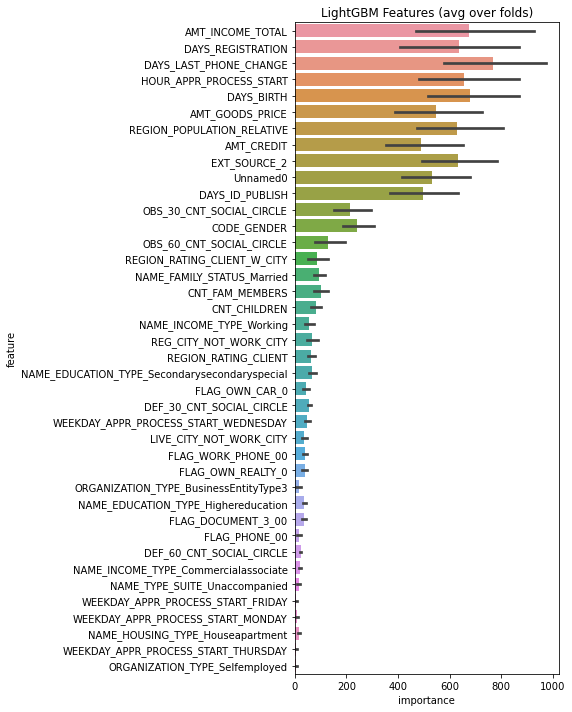

In [16]:
debug=False
with timer("Run LightGBM with kfold"):
    #try with num_folds= 2, increase to 10 later
    #this line is inserted to prevent error 'Do not support special JSON characters in feature name'
    train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    feat_importance = kfold_lightgbm(train_df, test_df, num_folds= 10, stratified= False, debug= debug)